# Working with PySWMM

If we _really_ want to supercharge our modeling workflow, we can tap into the excellent functionality provided by [pyswmm](https://www.pyswmm.org/). Here we'll walk through a simple example that runs a model with pyswmm and post-processes the results with `swmmio`.

We'll start by instantiating a `swmmio.Model` with a model hosted in the swmm-nrtestsuite repo.

In [5]:
from IPython.display import HTML
import swmmio
import pyswmm 

# path to a SWMM model from swmm-nrtestsuite
model_path = 'https://raw.githubusercontent.com/USEPA/swmm-nrtestsuite/refs/heads/dev/public/examples/Example1.inp'
model = swmmio.Model(model_path)
model.summary

{'num_subcatchments': 8,
 'num_conduits': 13,
 'num_junctions': 13,
 'num_outfalls': 1,
 'num_raingages': 1,
 'catchment_area': np.int64(71),
 'mean_subcatchment_slope': np.float64(0.010000000000000002),
 'total_conduit_length': np.int64(4300),
 'invert_range': np.int64(35)}

Next, we'll opening a {py:obj}`pyswmm.Simulation` context to run the model. At each simulation step, we'll store the flows at each link. When the simulation is done, we'll plots things in a simple timeseries chart.

<Axes: >

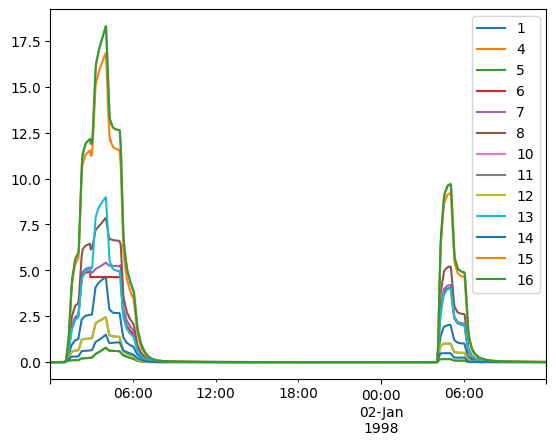

In [3]:

import pandas as pd

link_flows = dict()
# Run Simulation PySWMM
with pyswmm.Simulation(model.inp.path) as sim:
    
    for i, step in enumerate(sim):
        
        # store each link's flow in a dictionary 
        link_flows[sim.current_time] = {
            link_id: pyswmm.Links(sim)[link_id].flow 
            for link_id in model.inp.conduits.index
        }


pd.DataFrame(link_flows).T.plot()


## Animating Link Flows 
Let's turn our post-processing up a notch by animating the flows in the network: 

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

links_gdf = model.links.geodataframe
links_gdf = links_gdf.join(pd.DataFrame(link_flows))

# Example data: list of Axes objects
fig, ax = plt.subplots()
ax_list = [ax]

# Example function to update each Axes object
def update_axes(ax, frame):
    ax.clear()
    links_gdf.plot(linewidth=links_gdf[frame]+1, ax=ax, figsize=(10,10), capstyle='round')
    ax.set_axis_off()
    ax.set_title(f'{frame}')

# Function to update the plot for each frame
def update(frame):
    for ax in ax_list:
        update_axes(ax, frame)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=list(link_flows)[:750][::10], repeat=True)

# Close the figure to prevent it from being displayed
plt.close(fig)

# render the animation in the notebook
HTML(ani.to_jshtml())